# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
from gpt import gpt

In [4]:
# c = music21.corpus.parse(music21.corpus.chorales.Iterator(returnType='filename')[55]) c.show()

In [5]:
music21.environment.get('musicxmlPath')

PosixPath('/usr/bin/musescore')

In [6]:
path = Path('data/midi/v6/midi_transcribe/shortdur/')
get_files(path/'models/fastai/txl', recurse=True)

[PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep20.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep20_run1_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep20_run1.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hoo

In [7]:
model_path = 'fastai/txl/hook/1_ep20_run1_best'

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [8]:
bs=8
bptt=500

In [9]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t',
 array([ 2,  9,  8, 17, ..., 43, 29, 57, 29]))

In [10]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

In [70]:
data.train_dl.shuffle

True

In [73]:
data.train_dl.dl.shuffle

True

### Load Learner

In [11]:
cuda_enabled = torch.cuda.is_available()

In [12]:
# tfmerXL_lm_config['ctx_len'] = 512
# tfmerXL_lm_config['mem_len'] = 512

In [13]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:226: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [14]:
learn = learn.load(model_path)

## Done

In [15]:
# learn.show_results(rows=5, max_len=25)

In [16]:
# idx = 3
# idx = 8
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)
# file = files[idx]; file
file = np.random.choice(files); file

PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/c/camila-cabello/havana/chorus_key.txt')

In [17]:
# best = Path('data/midi/midi_transcribe_v3_shortdur/hooktheory/pianoroll/e/elton-john/tiny-dancer/pre-chorus_key.txt')

In [18]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(448,
 '|| t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2')

In [19]:
ns = str2stream(seed)
ns.show('midi')

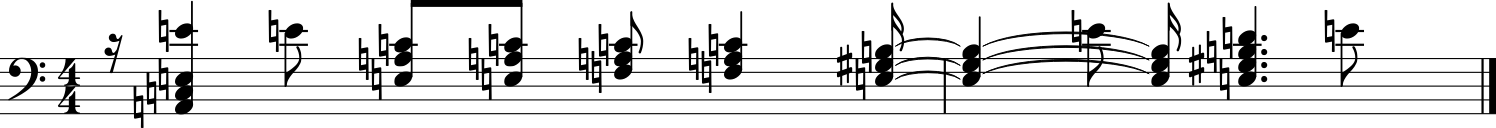

In [20]:
ns = str2stream(seed).show()

In [21]:
seed

'|| t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2'

In [22]:
# full song
str2stream(' '.join(notes)).show('midi')

### Debugging

In [23]:
def _select_hidden(model, idxs):
    if isinstance(model[0], TransformerXL):
        model[0].hidden = [h[idxs,:,:] for h in model[0].hidden]
    else:
        model[0].hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in model[0].hidden]
        model[0].bs = len(idxs)


## Beam search

In [24]:
import pdb

In [25]:
self = learn

In [26]:
text = seed

In [27]:
ds = self.data.single_dl.dataset
self.model.reset()
xb, yb = self.data.one_item(text)
start_idx = xb.clone()
nodes = None
scores = xb.new_ones(1).float()

In [28]:
k = 0

In [32]:
beam_sz = 20

In [29]:
top_k = 10

In [39]:
self.model[0].hidden[0].shape[0], xb.shape[0]

(10, 10)

In [40]:
if self.model[0].hidden[0].shape[0] != xb.shape[0]: 
    print('REsetting')
    self.model.reset()

In [41]:
out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
values, indices = out.topk(top_k, dim=-1)
scores = (-values * scores[:,None]).view(-1)

In [42]:
self.model[0].hidden[0].shape, xb.shape

(torch.Size([10, 81, 410]), torch.Size([10, 1]))

In [43]:
indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
sort_idx = scores.argsort()[:beam_sz]
scores = scores[sort_idx]
nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                   indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
nodes = nodes.view(-1, nodes.size(2))[sort_idx]

In [44]:
_select_hidden(self.model, indices_idx[sort_idx])

In [36]:
if nodes is None: 
    nodes = indices[0][:,None]
    _select_hidden(self.model, [0] * nodes.size(0))
else:
    indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
    sort_idx = scores.argsort()[:beam_sz]
    scores = scores[sort_idx]
    nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                       indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
    nodes = nodes.view(-1, nodes.size(2))[sort_idx]
    _select_hidden(self.model, indices_idx[sort_idx])
xb = nodes[:,-1][:,None]

In [37]:
k += 1

In [38]:
nodes

tensor([[ 9],
        [ 2],
        [26],
        [15],
        [16],
        [58],
        [22],
        [20],
        [75],
        [28]], device='cuda:0')

In [46]:
xb.shape

torch.Size([10, 1])

In [39]:
with torch.no_grad():
    for k in range(n_words):
        out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
        values, indices = out.topk(top_k, dim=-1)
        scores = (-values * scores[:,None]).view(-1)
        if nodes is None: 
            nodes = indices[0][:,None]
            _select_hidden(self.model, [0] * nodes.size(0))
        else:
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                               indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            _select_hidden(self.model, indices_idx[sort_idx])
        xb = nodes[:,-1][:,None]
#             pdb.set_trace()
if temperature != 1.: scores.div_(temperature)
node_idx = torch.multinomial(1-scores, 1).item()
return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx]], sep=None)))

NameError: name 'n_words' is not defined

In [52]:
learn.model[0].hidden[0].shape

torch.Size([10, 1, 410])

In [53]:

def beam_search(self, text:str, n_words:int, top_k:int=10, beam_sz:int=200, temperature:float=1., sep:str=' ',
                decoder=decode_spec_tokens):
    "Return the `n_words` that come after `text` using beam search."
    ds = self.data.single_dl.dataset
    self.model.reset()
    xb, yb = self.data.one_item(text)
    start_idx = xb.clone()
    nodes = None
    scores = xb.new_ones(1).float()
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            if self.model[0].hidden[0].shape[0] != xb.shape[0]: self.model.reset()
            out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values * scores[:,None]).view(-1)
            if nodes is None: 
                nodes = indices[0][:,None]
                _select_hidden(self.model, [0] * nodes.size(0))
            else:
                indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
                sort_idx = scores.argsort()[:beam_sz]
                scores = scores[sort_idx]
                nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                   indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
                nodes = nodes.view(-1, nodes.size(2))[sort_idx]
                _select_hidden(self.model, indices_idx[sort_idx])
            xb = nodes[:,-1][:,None]
    if temperature != 1.: scores.div_(temperature)
    node_idx = torch.multinomial(1-scores, 1).item()
    return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx]], sep=None)))


In [54]:
p = beam_search(learn, seed, n_words=150); p

'|| t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nF4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nD4 t2 nD4 t2 || t1 nE3 t2 nG#3 t2 nG#3 t2 nB3 t2 nC#4 t10 nB4 t7 nB5 t15 nG#6 t17 nC7 t3 nC7 t9 nA6 t15 nG#6 t8 nG#6 || t5 nC4 t8 nC#4 t26 nC#4 t6 nA4 t3 nC5 t24 nE-5 t32 || t8 nB3 t9 nG#4 t5 nF#5 t9 xxbos nA4 t5 nG5 t10 nE6 t11 xxbos nG5 t11 nF6 t5 nC7 t10 nB6 t3 xxbos nB-6 t13 nA6 t6 nE-7 t7 nG#7 t10 nC#7 t3 nF#7 t11 nB-5 t6 nF7 t11 nC7 t5 nE7 t11 nA6 t8 nD7 t2 nG7 t5 nE-7 t7 nC#7 t9 nF6 t9 nG#7 t5 nB6 t10 nB-6 t12 nG#6 t7 nE-6 t2 nE-6 t12 nD7 t12 nE-6 t16 nF#6 t11 nC#7 t13 nB6 t4 nB6 t11 nB-6 t16 nF7 t9 nF#7 t7 nB-6 t9 || t6 nG#6 t8'

In [55]:
str2stream(p).show('midi')

't'


't'


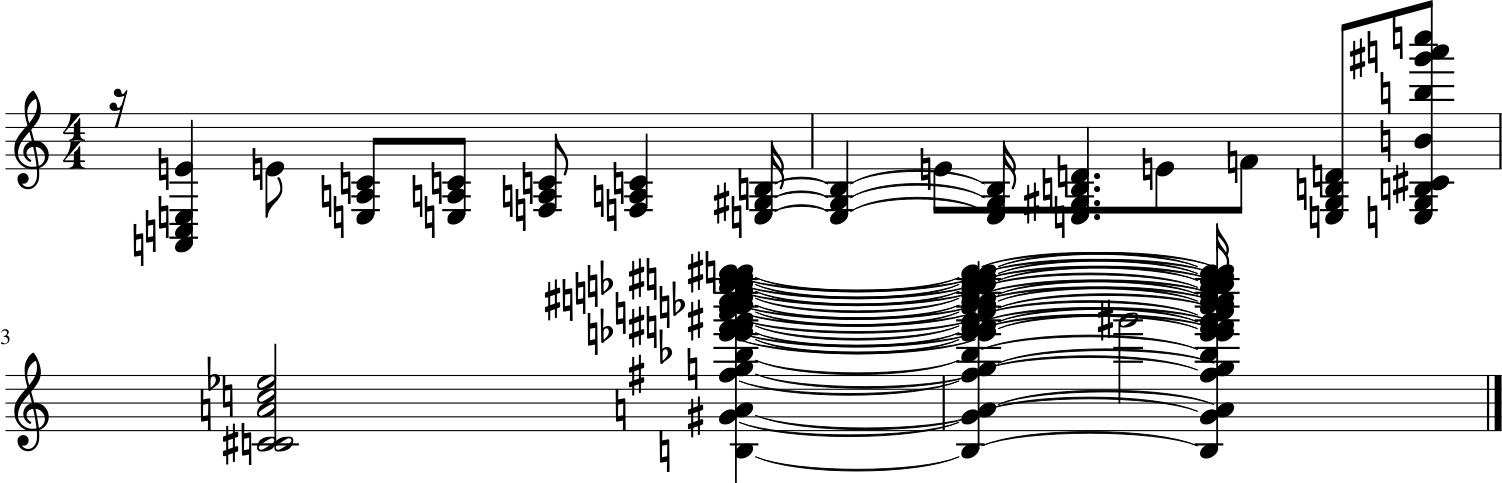

In [56]:
str2stream(p).show()

### New predict with memory

In [24]:
ob = learn.data.one_batch()

In [25]:
ob[0].shape

torch.Size([8, 500])

In [26]:
xb,yb = learn.data.one_item(seed)

In [27]:
xb.shape

torch.Size([1, 80])

In [28]:
xb.new_tensor([1,2,3])[None].shape

torch.Size([1, 3])

In [29]:
learn.model.reset()

In [30]:
[h.shape for h in learn.model[0].hidden]

[torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0])]

In [31]:
out = learn.model(xb)

In [32]:
out[0].shape

torch.Size([1, 80, 507])

In [33]:
out[1][0].shape

torch.Size([1, 80, 410])

In [34]:

def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
            decoder=decode_spec_tokens):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    xb,yb = self.data.one_item(text)
    new_idx = []
    for _ in progress_bar(range(n_words), leave=False):
        self.model.reset()
        res = self.pred_batch(batch=(xb,yb))[0][-1]
        if len(new_idx) == 0: _select_hidden(self.model, [0])
        if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: res[res < min_p] = 0.
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
        new_idx.append(idx)
        xb = xb.new_tensor(new_idx)[None]
    return sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

In [35]:
p = predict(learn, seed, n_words=150); p

'nA3 t1 || t0 nG3 t2 nB3 t2 nD4 t2 nB5 t1 || t0 nB5 t1 || t0 nB5 t1 || t0 nB5 t1 || t0 nB5 t1 || t0 nB5 t1 || t0 nG3 t2 nB3 t2 nD4 t2 nD6 t1 || t0 nD6 t1 || t0 nD6 t1 || t0 nD6 t1 || t0 nG3 t2 nB3 t2 nD4 t2 nD6 t1 || t0 nD6 t1 || t0 nD6 t1 || t0 nD6 t1 || t0 nG3 t2 nB3 t2 nD4 t2 nD6 t1 || t0 nD6 t1 || t0 nE3 t16 nG3 t16 nB3 t16 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0 nE4 t1 || t0'

In [36]:
str2stream(p).show('midi')

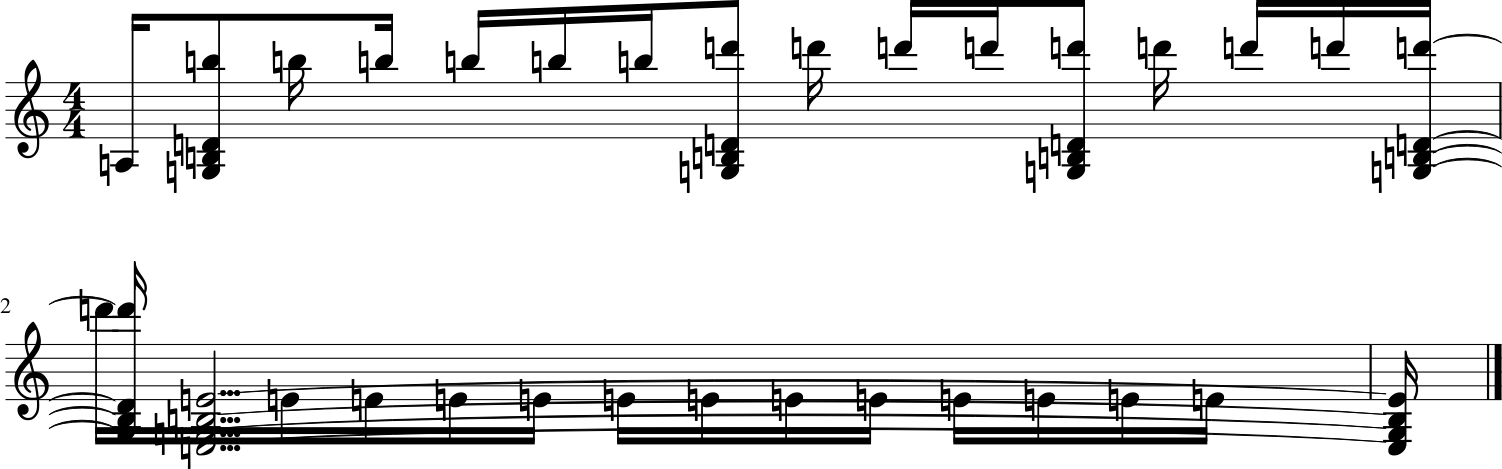

In [37]:
str2stream(p).show()

In [43]:
%debug

> <ipython-input-23-629a6ccbaffb>(3)<listcomp>()
      1 def _select_hidden(model, idxs):
      2     if isinstance(model[0], TransformerXL):
----> 3         model[0].hidden = [h[:,idxs,:] for h in model[0].hidden]
      4     else:
      5         model[0].hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in model[0].hidden]

ipdb> idxs
tensor([  0,   0,   0,   0,   1,   2,   1,   2,   3,   0,   0,   0,   0,   3,
          1,   0,   1,   0,   2,   4,   2,   5,   4,   3,   3,   5,   6,   1,
          1,   1,   1,   6,   2,   2,   2,   2,   4,   1,   4,   1,   5,   2,
          3,   3,   3,   5,   3,   2,   7,   6,   3,   6,   7,   3,   8,   4,
          4,   4,   4,   8,   9,  10,  11,   5,   5,   5,   5,   4,   9,  10,
         11,   4,   7,   5,   6,   6,   6,   7,   6,  12,   5,   8,  12,   6,
         13,   8,  14,   6,  15,  13,   9,  16,  17,  18,  10,  14,   9,  11,
         10,  11,  15,  16,  17,  19,  18,  20,   7,   7,  21,   7,   7,  19,
         12,  22,  20,  12,  21,   7, 

ipdb> up
> <ipython-input-41-084a9454b555>(26)beam_search()
     24                                    indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
     25                 nodes = nodes.view(-1, nodes.size(2))[sort_idx]
---> 26                 _select_hidden(self.model, indices_idx[sort_idx])
     27             xb = nodes[:,-1][None,:]
     28 #             pdb.set_trace()

ipdb> nodes
*** RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/aten/src/THC/THCGeneral.cpp:405
ipdb> quit


In [101]:
%debug

> /home/ubuntu/fastai/fastai/text/models/transformer.py(104)_apply_attention()
    102         #parameters of the model common between all layers, mask to avoid cheating and mem the previous hidden states.
    103         bs,x_len,seq_len = x.size(0),x.size(1),r.size(0)
--> 104         context = x if mem is None else torch.cat([mem, x], dim=1)
    105         wq,wk,wv = torch.chunk(self.attention(context), 3, dim=-1)
    106         wq = wq[:,-x_len:]

ipdb> mem.shape
torch.Size([1, 10, 410])
ipdb> x.shape
torch.Size([10, 1, 410])
ipdb> quit


### Predictions without beam search

In [79]:
pred_out = learn.predict(seed, n_words=150, temperature=2); pred_out

'|| t0 nA2 t16 nC3 t16 nE3 t16 nC4 t2 || t1 nC4 t2 || t1 nD4 t2 || t1 nC4 t2 || t1 nC4 t2 || t1 nC4 t2 || t1 nD4 t8 || t3 nF2 t8 nA2 t8 nC3 t8 || t7 nF2 t8 nA2 t8 nC3 t8 nD3 t8 || t7 nC3 t16 nE3 t16 nG3 t16 nC4 t2 || t1 nC4 t2 || t1 nD4 t2 || t1 nC4 t2 || t1 nC4 t2 || t1 nC4 t18 nG#5 t12 nG#5 t13 || t13 nF2 t24 nG3 t6 nG4 t42 nF#5 t66 || t5 nG5 t47 || t21 nC#4 t14 nC6 nF6 t19 nB-6 t19 || t154 nC#2 t80 || t257 nG6 t111 || nE9 t1 t25 nB7 t25 || t46 nD7 nF1 t72 nF2 t54 nD6 t63 t174 t93 t57 t104 nF t57 || t37 nE6 t65 t9 t47 t314 t56 nG#5 t88 t165 t74 t39 t143 t175 t340 t248 nE-6 t36 nB-6 t48 nC#7 t241 t130 nC#9 t8 || t58 t251 t66 nC6 t1 nC#6 t2 nF6 t1 nC#7 t60 nA7 nB-5 t26 nF6 t48 || t0 nC#4 t84 nE-4 t332 t155 t237 nA7 t67 nB6 t84 nC#7 t82 nD t337 t74 t279 t65 t274 t74 t369 t106 t168 t123 t259 t58 t236 t149 nD6 t22 nG6 t348 t42 t248 t333 t267 t257 t339 nB-0 t296 t200 t123 t337 t79 t73 t186 t240 t544'

In [57]:
pred_out = learn.predict_old(seed, n_words=200); pred_out

'|| t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2 || t1 nE3 t2 nA3 t2 nA3 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2'

In [58]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2 || t1 nE3 t2 nA3 t2 nA3 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2'

In [59]:
ns = str2stream(pred_only)
ns.show('midi')

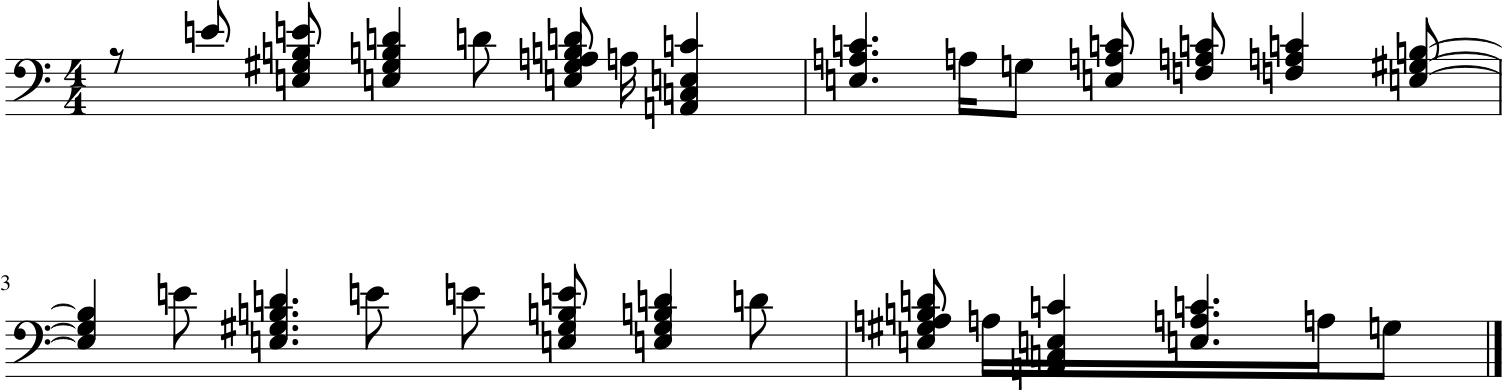

In [60]:
ns.show()

In [61]:
str2seq(pred_only)

[[],
 [],
 [E4t2],
 [],
 [E3t2, G#3t2, B3t2, E4t2],
 [],
 [E3t4, G#3t4, B3t4, D4t2, D4t4],
 [],
 [D4t2],
 [],
 [E3t2, G#3t2, A3t1, B3t2, D4t10],
 [A3t1],
 [A2t4, C3t4, E3t4, C4t9],
 [],
 [],
 [],
 [E3t6, A3t6, C4t6],
 [],
 [],
 [A3t1],
 [G3t2],
 [],
 [E3t2, A3t2, A3t2, C4t2],
 [],
 [F3t2, A3t10, A3t2, C4t2],
 [],
 [F3t4, A3t4, C4t4],
 [],
 [],
 [],
 [E3t6, G#3t6, B3t6],
 [],
 [],
 [],
 [E4t2],
 [],
 [E3t6, G#3t6, B3t6, D4t2, D4t6],
 [],
 [E4t2],
 [],
 [E4t2],
 [],
 [E3t2, G#3t2, B3t2, E4t2],
 [],
 [E3t4, G#3t4, B3t4, D4t2, D4t4],
 [],
 [D4t2],
 [],
 [E3t2, G#3t2, A3t1, B3t2, D4t10],
 [A3t1],
 [A2t4, C3t4, E3t4, C4t9],
 [],
 [],
 [],
 [E3t6, A3t6, C4t6],
 [],
 [],
 [A3t1],
 [G3t2]]

In [62]:
ns = str2stream(pred_out)
ns.show('midi')

### Fastai beam search

In [117]:
[h.shape for h in learn.model[0].hidden]

[torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410])]

In [118]:
pred_out = learn.beam_search(seed, n_words=200); pred_out

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 10 and 1 in dimension 0 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:83

In [40]:
xb,yb = learn.data.one_item(seed)

In [41]:
xb.shape

torch.Size([1, 80])

### Beam search

In [63]:
from beam_search import *

In [64]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=1)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

'|| t0 nE5 t2 || t0 nD5 t1 || t0 nC5 t1  || t0 nE5 t2 || t0 nD5 t1 || t0 nC5 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 xxbos || t0 nA2 t16 nC3 t16 nE3 t16 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 ||'

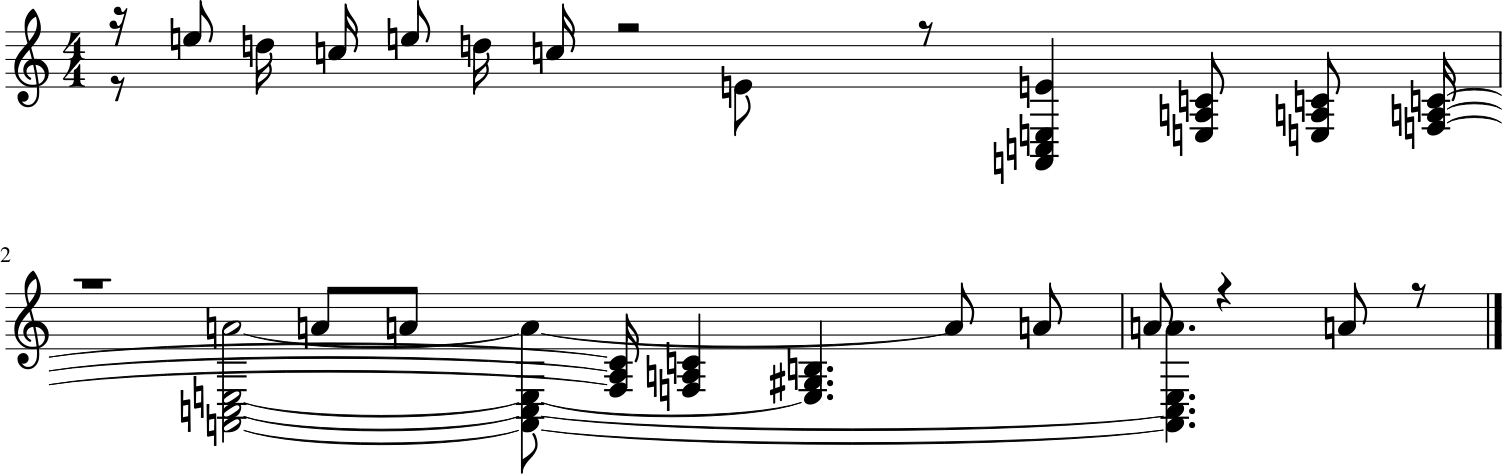

In [65]:
ns_only = str2stream(pred_beam_only).show()

In [66]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

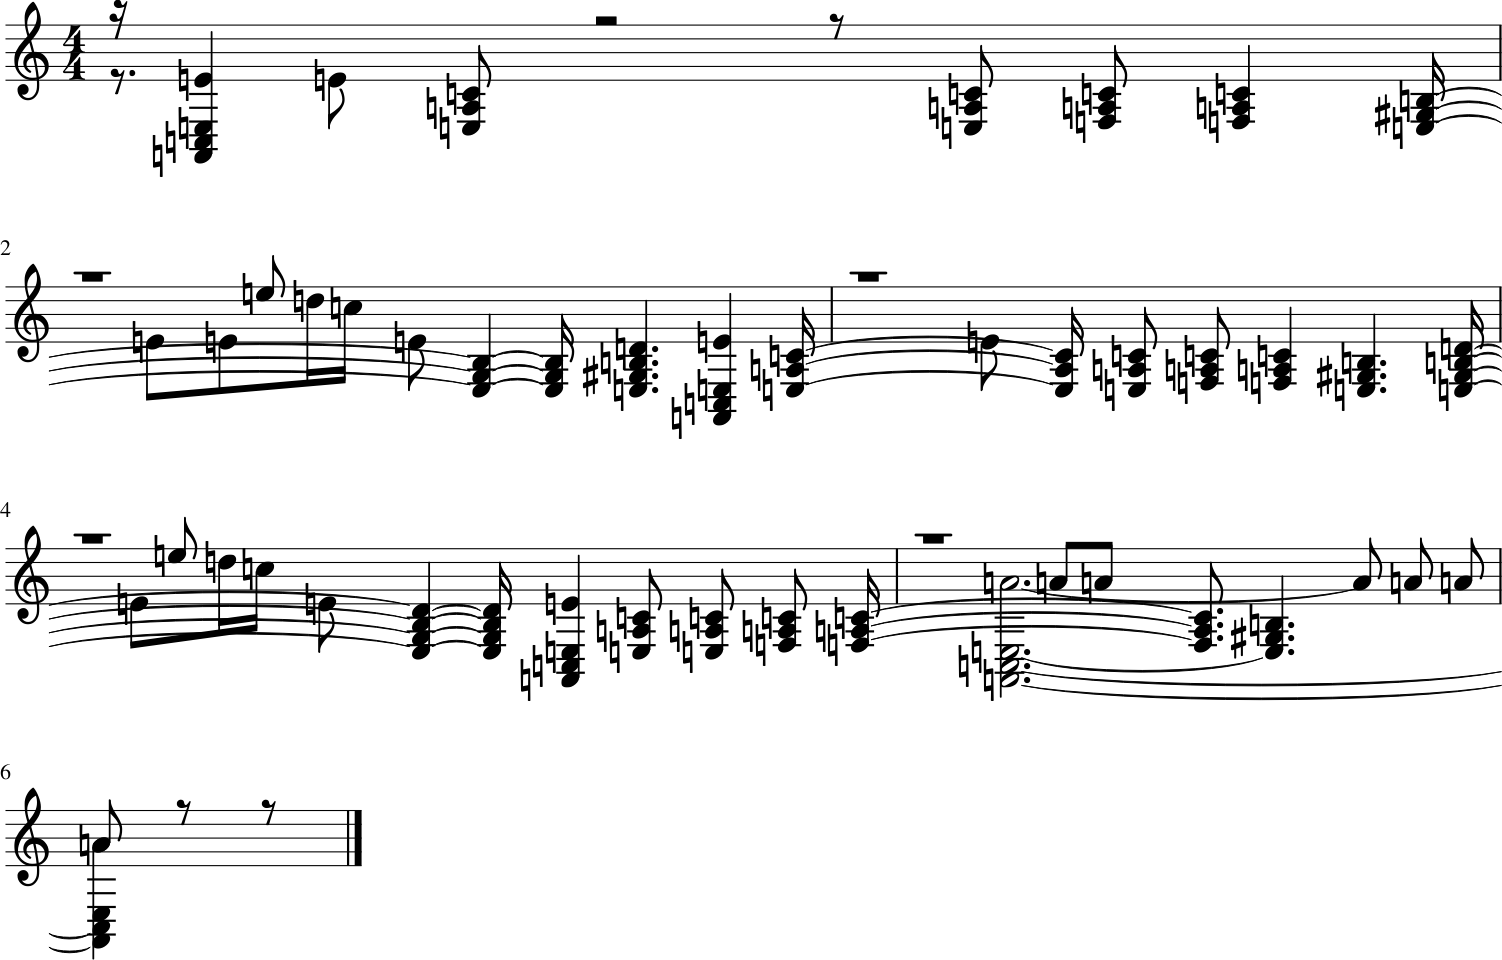

In [67]:
ns = str2stream(pred_beam).show()

In [68]:
ns = str2stream(pred_beam)
ns.show('midi')